## Run simulation and optimizations for the folded cascode example


In [1]:
import json
import circuits as cir
import optimizers as opt
import ngspice
import pandas as pd

import importlib
importlib.reload(cir)
importlib.reload(opt)
importlib.reload(ngspice)


<module 'ngspice' from '/home/nlourenco/workspace-code/BAICO/BAIcO/src/ngspice.py'>

In [2]:
#load the cicruit definitions and targets defined in circuit_setup.json
folded_cascode = cir.Circuit("./circuit_examples/ptm130_folded_cascode/", corners=None)

#load a sample sizing
with open("./circuit_examples/ptm130_folded_cascode/sizing_example.json", 'r') as file:
    sizing = json.load(file)

simulation_result = folded_cascode.simulate(sizing)


print("Simulation Results Typ Only")

df = pd.DataFrame(simulation_result[0]).transpose()

df['CL'] *= 1e12  
df.rename(columns = {"CL": "CL[pF]"}, inplace=True)  
print(df)


Simulation Results Typ Only
    CL[pF]  DELTA_MNM1  DELTA_MNM2  DELTA_MNM3  DELTA_MNM4  DELTA_MNM5  \
TT     6.0    0.585495    0.739938    0.617564    0.619046    0.413995   

    DELTA_MNM6  DELTA_MNM7  DELTA_MNM8  DELTA_MPM0  ...  VOV_MNM5  VOV_MNM6  \
TT    0.639173    0.402403    0.402872    0.472546  ...  0.001432  0.000963   

    VOV_MNM7  VOV_MNM8  VOV_MPM0  VOV_MPM1  VOV_MPM3  VOV_MPM4  VOV_MPM5  \
TT -0.016224 -0.016224   0.37476  0.103984  1.307041  1.307041  0.405695   

    VOV_MPM6  
TT  0.407171  

[1 rows x 42 columns]


In [3]:
#load the cicruit definitions and targets defined in circuit_setup.json with corners from corners.inc
folded_cascode = cir.Circuit("./circuit_examples/ptm130_folded_cascode/")

#load a sample sizing
with open("./circuit_examples/ptm130_folded_cascode/sizing_example.json", 'r') as file:
    sizing = json.load(file)

simulation_result = folded_cascode.simulate(sizing)


print("Simulation Results All Corners")
df = pd.DataFrame(simulation_result[0]).transpose()

# rescale CL to show not 0 in df
df['CL'] *= 1e12
df.rename(columns = {"CL": "CL[pF]"}, inplace=True)  
print(df)

Simulation Results All Corners
                       CL[pF]       GDC         GBW  PM_NEGATIVE        GPS  \
FF_VDD_MAX_TEMP_MAX       6.0  87.51435  32338310.0    -122.7734 -18.703350   
SS_VDD_MAX_TEMP_MAX       6.0  95.32268  23641690.0    -131.6557  -1.444409   
TT                        6.0  88.39221  31793610.0    -122.3191  -3.418371   
SS_VDD_MAX_TEMP_MIN       6.0  69.53510  46737210.0    -108.8653 -14.417560   
SS_VDD_MIN_TEMP_MAX       6.0 -86.95084         NaN          NaN -75.768650   
FF_VDD_MAX_TEMP_MIN       6.0  68.64928  58458860.0    -107.7896 -14.566390   
SS_VDD_MIN_TEMP_MIN       6.0  80.83673  39554440.0    -114.2310  -5.460861   
FF_VDD_MIN_TEMP_MAX       6.0  98.37739  18233250.0    -132.4969   6.757086   
FF_VDD_MIN_TEMP_MIN       6.0  72.23919  42161240.0    -106.8764 -21.388510   
SNFP_VDD_MAX_TEMP_MIN     6.0  63.25632  50487600.0    -106.5604 -13.049850   
SNFP_VDD_MIN_TEMP_MAX     6.0 -87.04048         NaN          NaN -63.453340   
SNFP_VDD_MAX_TEMP_MAX

In [4]:
obj,cstr,log = folded_cascode.target.evaluate(simulation_result[0])

print("Objectives")

print( {folded_cascode.objectives[i][0]:(obj[i]*folded_cascode.objectives[i][1]) for i in range(len(obj))})

Objectives
{'IDD': 0.001285138, 'GBW': -inf, 'GDC': -98.38497}


## Optimizing in Nominal conditions

Outputs are save to the output_folder

This can take a while.


In [7]:
import random
from datetime import datetime
import numpy as np
import pandas as pd
import os


seed = 42
np.random.seed(seed)
random.seed(seed)
nsga2 = opt.NSGA2()

output_folder = "./run/ptm130_folded_cascode/"


if not os.path.exists(output_folder):
    os.makedirs(output_folder)


i = 0
folded_cascode = cir.Circuit("./circuit_examples/ptm130_folded_cascode/", corners=None)
for pop, pop_obj,  pop_cstr, pop_data, evals, front_no in nsga2.minimize(
        folded_cascode,pop_size=256, evaluations=256*100, mutation=0.1, crossover=0.6):
        
        print(i, pop_cstr[pop_cstr.argmax()], datetime.now().time())
        with open("{}history256_{}_{}.json".format(output_folder,seed, i), "w") as file: 
            json.dump(
            {
                "pop":json.loads(pd.DataFrame(data=pop, columns=folded_cascode.parameters).to_json(orient="records")),
                "obj":json.loads(pd.DataFrame(data=pop_obj, columns=folded_cascode.objectives).to_json(orient="records")),
                "cstr":pop_cstr.tolist(),
                "data":pop_data,
                "evals":evals,
                "fn":[ str(fn) for fn in front_no.tolist()]
            },
            file  
            )
        i = i + 1


0 [-2.46806649] 08:18:30.130499
1 [-1.08976006] 08:18:39.084037
2 [-1.08976006] 08:18:46.344625
3 [-1.08976006] 08:18:55.580950
4 [-1.08976006] 08:19:06.706165
5 [-0.42640318] 08:19:18.263612
6 [-0.42640318] 08:19:28.406799
7 [-0.38012631] 08:19:38.996622
8 [-0.30998951] 08:19:48.382255
9 [-0.27559982] 08:19:58.393053
10 [-0.27559982] 08:20:09.125839
11 [-0.27559982] 08:20:21.005414
12 [-0.22000874] 08:20:32.261512
13 [-0.22000874] 08:20:44.859261
14 [-0.22000874] 08:20:59.126707
15 [-0.22000874] 08:21:11.804097
16 [-0.21890235] 08:21:24.811387
17 [-0.13215336] 08:21:37.946179
18 [-0.07368782] 08:21:51.583265
19 [-0.07226053] 08:22:05.783528
20 [-0.05250202] 08:22:20.718910
21 [-0.02386623] 08:22:35.441119
22 [-0.02386623] 08:22:49.575234
23 [-0.00840327] 08:23:04.470012
24 [-0.00182818] 08:23:18.458989
25 [0.] 08:23:32.252553
26 [0.] 08:23:46.800791
27 [0.] 08:24:01.009813
28 [0.] 08:24:15.199485
29 [0.] 08:24:29.431627
30 [0.] 08:24:43.550772
31 [0.] 08:24:57.421723
32 [0.] 08:25:10.

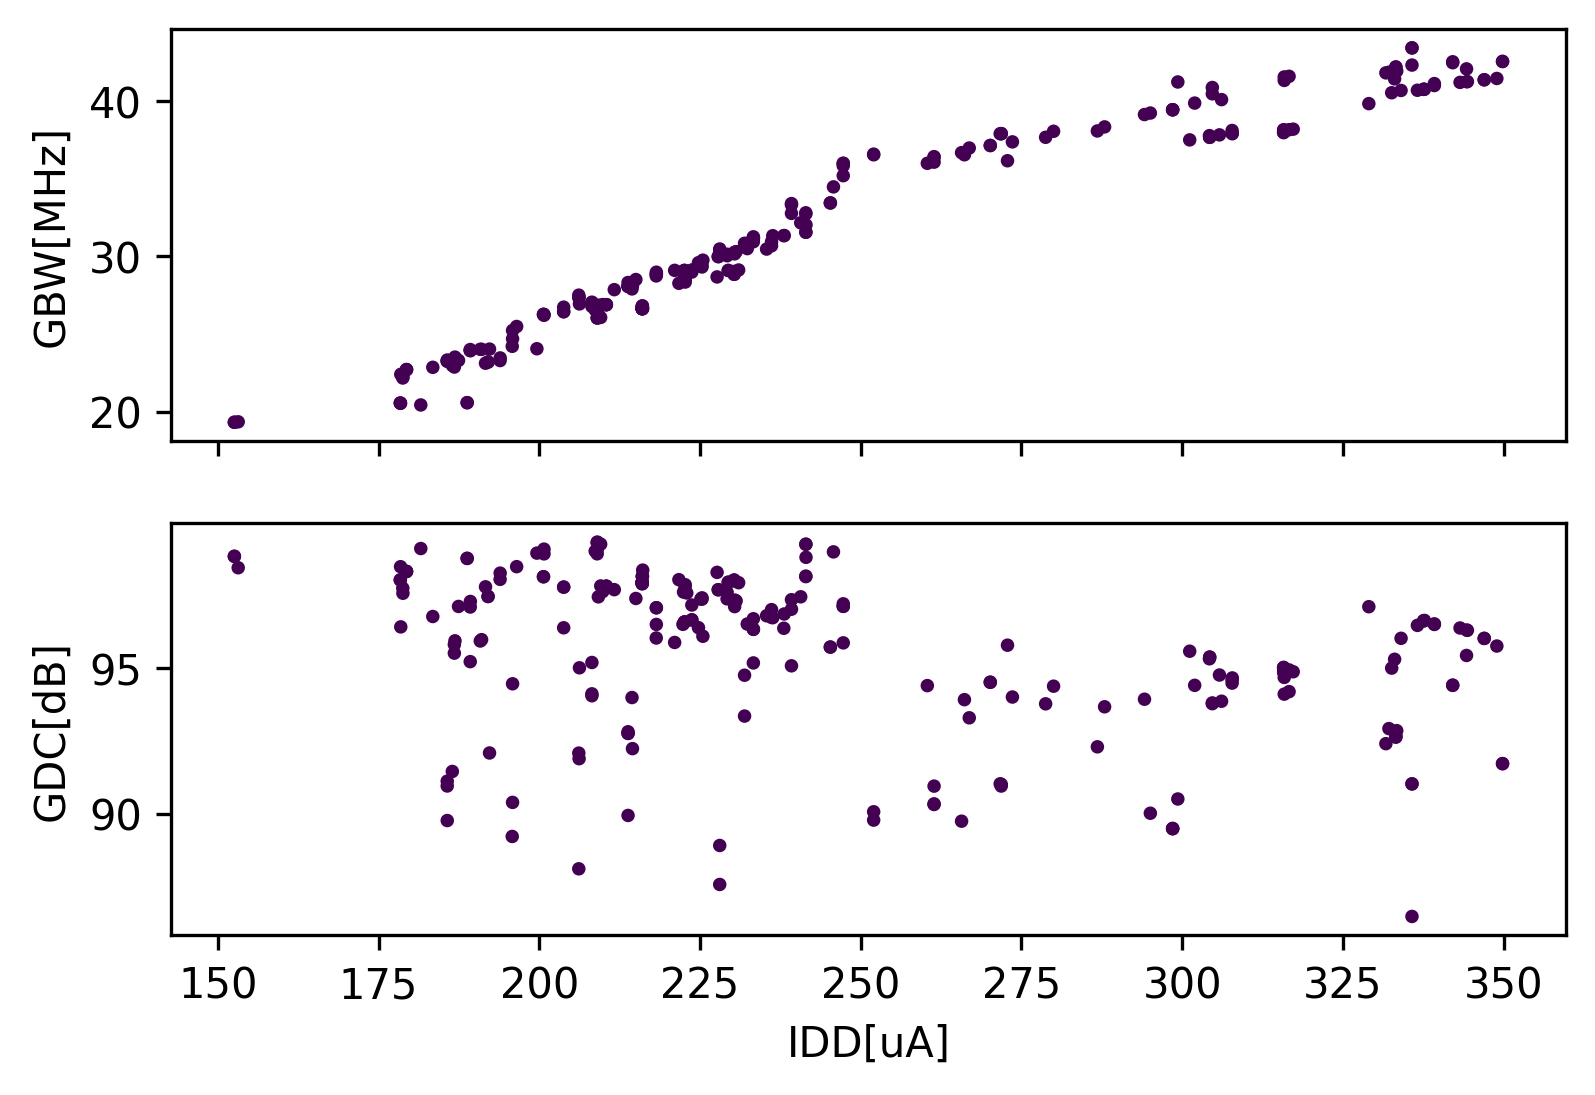

In [31]:
import plot_utils 
importlib.reload(plot_utils)

plot_utils.plt_pof(["{}history256_{}_{}.json".format(output_folder,seed, 100)], scales = [("[uA]", 1e6),("[MHz]", 1e-6),("[dB]", 1.0)])

